<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/LC50%2BPyspark_4_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code B is better

### Overview of Code A: Simplified Accuracy–Interpretability Evaluation

This script implements a controlled and simplified experimental pipeline to evaluate the trade-off between predictive performance and interpretability for credit default prediction using the Lending Club LC_50K dataset. To ensure stability and robustness of explanation methods, the analysis deliberately restricts the feature space to a small set of key numeric variables and avoids high-dimensional categorical encodings. Multiple tree-based models (Random Forest, XGBoost, LightGBM) are evaluated under different class imbalance handling strategies using 4-fold stratified cross-validation. Interpretability is assessed using SHAP, Banzhaf, and Owen value-based explanations, with quantitative metrics capturing explanation stability and consistency across folds. This controlled setting serves as a diagnostic and baseline study, enabling reliable comparison of explanation methods without confounding effects from feature sparsity or dimensionality.


Dataset Schema:
root
 |-- id: integer (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- revenue: double (nullable = true)
 |-- dti_n: double (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- fico_n: double (nullable = true)
 |-- experience_c: integer (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- home_ownership_n: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- Default: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- desc: string (nullable = true)


Total Records: 50000
Columns: 15

First 5 rows:
+--------+--------+--------+-----+---------+------+------------+----------+------------------+----------------+----------+--------+-------+--------------------+--------------------+
|      id| issue_d| revenue|dti_n|loan_amnt|fico_n|experience_c|emp_length|           purpose|home_ownership_n|addr_state|zip_code|Default|         

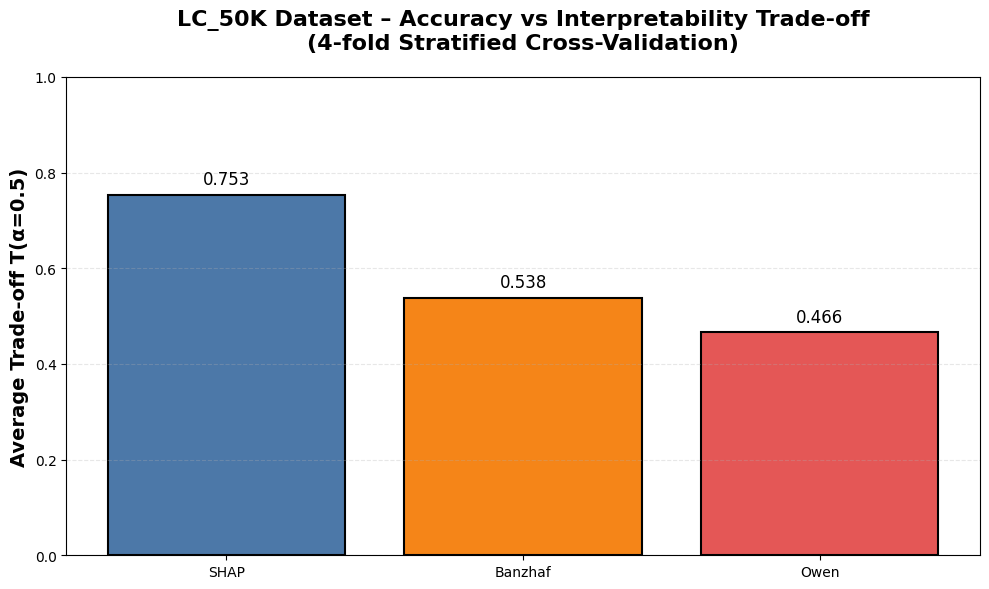

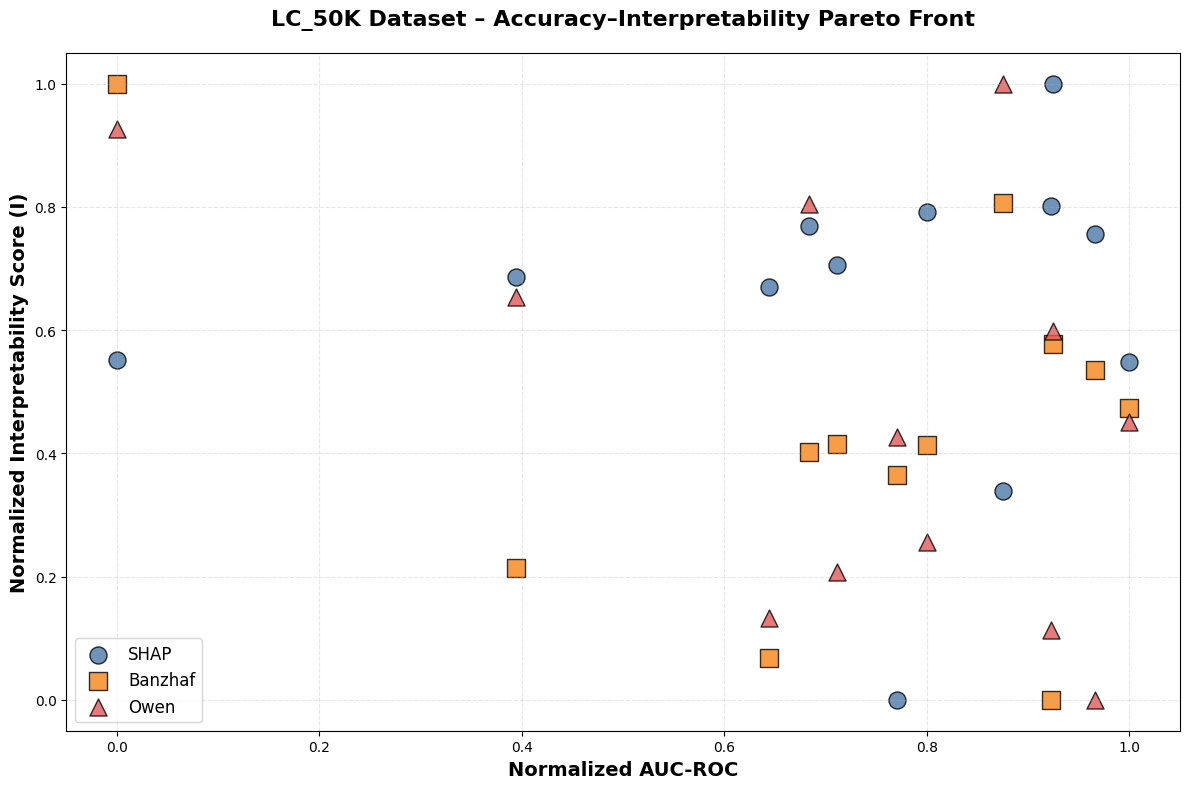

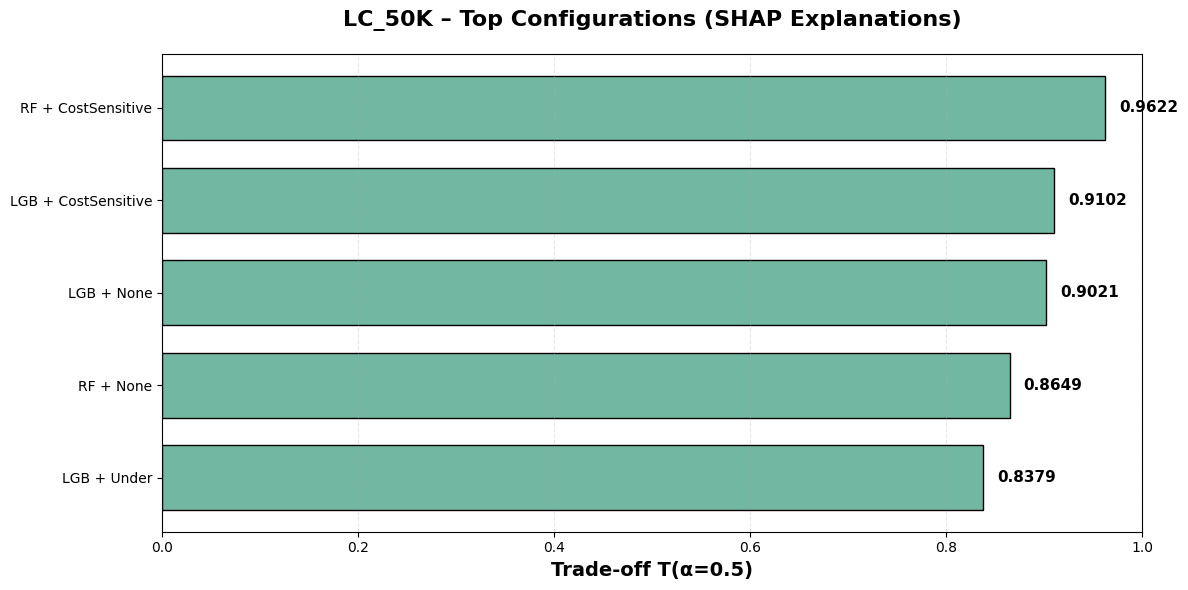

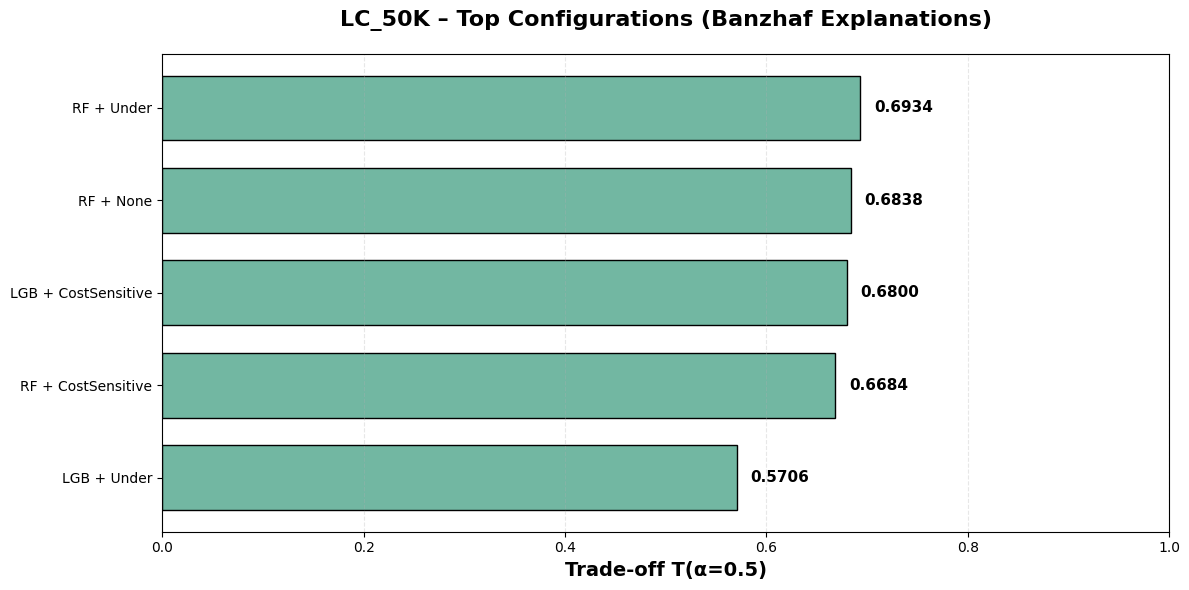

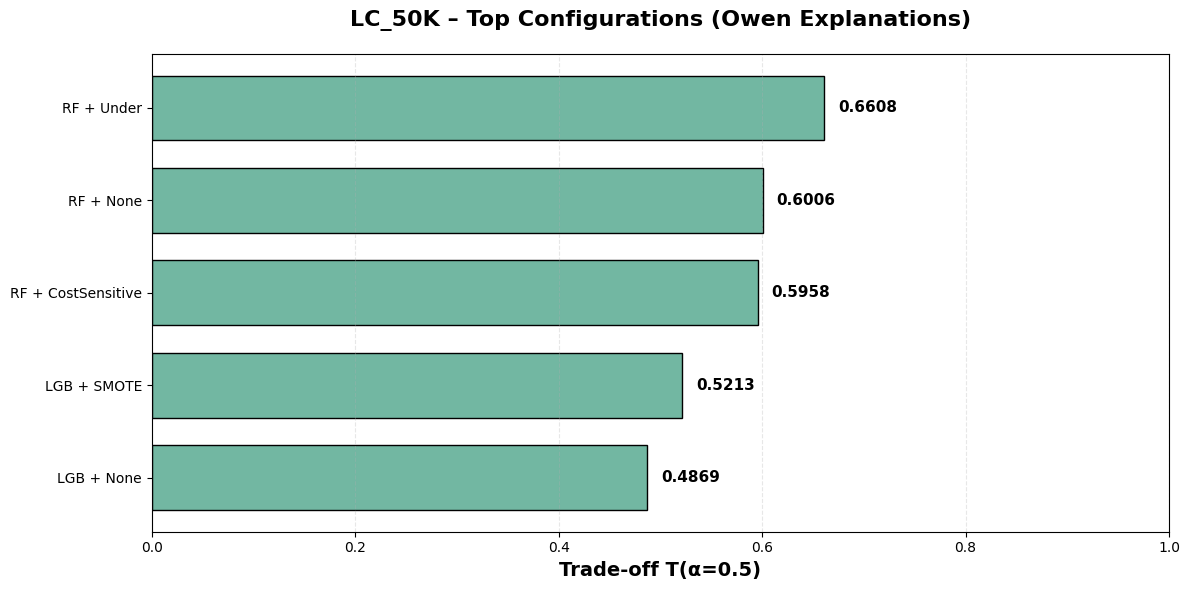


Generating LaTeX Tables for Thesis

LaTeX TABLE — SHAP:
\begin{table}[h]
\caption{LC_50K Dataset – SHAP Explanation Results (4-fold CV)}
\label{tab:lc50k_shap}
\begin{tabular}{llrrrrr}
\toprule
Model & Sampler & AUC & Stability & Jaccard & I & T(α=0.5) \\
\midrule
RF & None & 0.623100 & 0.593400 & 0.750000 & 0.671700 & 0.864900 \\
RF & SMOTE & 0.614500 & 0.517600 & 0.583300 & 0.550400 & 0.586100 \\
RF & Under & 0.618400 & 0.501100 & 0.750000 & 0.625600 & 0.739900 \\
RF & CostSensitive & 0.620300 & 0.543300 & 1.000000 & 0.771700 & 0.962200 \\
XGB & None & 0.609700 & 0.397600 & 1.000000 & 0.698800 & 0.723300 \\
XGB & SMOTE & 0.585600 & 0.344600 & 1.000000 & 0.672300 & 0.365700 \\
XGB & Under & 0.600400 & 0.404700 & 1.000000 & 0.702300 & 0.603500 \\
XGB & CostSensitive & 0.612300 & 0.413100 & 1.000000 & 0.706500 & 0.767600 \\
LGB & None & 0.620200 & 0.455500 & 1.000000 & 0.727800 & 0.902100 \\
LGB & SMOTE & 0.611200 & 0.441100 & 1.000000 & 0.720500 & 0.772500 \\
LGB & Under & 0.615600 & 

In [ ]:
# -*- coding: utf-8 -*-
"""Lending Club LC_50K Dataset – Rigorous Accuracy–Interpretability Study"""

# ============================================================
# 1. Install & Imports
# ============================================================
!pip install -q imbalanced-learn shap lightgbm xgboost seaborn scikit-learn pandas numpy matplotlib pyspark

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace
from pyspark.sql.types import DoubleType, IntegerType
import pyspark.sql.functions as F

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import shap

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 2. Initialize Spark and Load Data
# ============================================================
# Initialize Spark session
spark = SparkSession.builder \
    .appName("LC_50K_Analysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Load the CSV file
df_spark = spark.read.csv("LC_50K.csv", header=True, inferSchema=True)

print("Dataset Schema:")
df_spark.printSchema()
print(f"\nTotal Records: {df_spark.count()}")
print(f"Columns: {len(df_spark.columns)}")

# ============================================================
# 3. Data Preprocessing for PySpark
# ============================================================
# Show first few rows
print("\nFirst 5 rows:")
df_spark.show(5)

# Check for missing values
print("\nMissing values per column:")
for column in df_spark.columns:
    missing_count = df_spark.filter(col(column).isNull()).count()
    if missing_count > 0:
        print(f"{column}: {missing_count}")

# Check target distribution
print("\nTarget variable (Default) distribution:")
df_spark.groupBy("Default").count().show()

# ============================================================
# 4. Feature Engineering and Selection - SIMPLIFIED
# ============================================================
# Since we're having issues with many features after encoding,
# let's use a simpler set of features

# First, let's handle missing values
df_spark = df_spark.dropna(subset=["Default"])

# Select and prepare key features
selected_features = [
    "revenue", "dti_n", "loan_amnt", "fico_n", "experience_c"
]

# Ensure all selected features exist
existing_features = [col for col in selected_features if col in df_spark.columns]

# Handle missing numeric values
for col_name in existing_features:
    if col_name in df_spark.columns:
        median_val = df_spark.approxQuantile(col_name, [0.5], 0.01)[0]
        df_spark = df_spark.fillna({col_name: median_val})

print(f"\nUsing features: {existing_features}")

# ============================================================
# 5. Convert to Pandas for Modeling
# ============================================================
print("\nConverting to Pandas DataFrame...")

# Create final DataFrame with selected features and target
final_cols = existing_features + ["Default"]
df_final_spark = df_spark.select(final_cols)

# Convert to Pandas
df = df_final_spark.toPandas()

print(f"Final dataset shape: {df.shape}")
print(f"Target distribution:\n{df['Default'].value_counts(normalize=True)}")

# ============================================================
# 6. Prepare Data for Modeling
# ============================================================
# Separate features and target
X = df.drop('Default', axis=1)
y = df['Default'].astype(int)

# Identify numeric columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nNumeric columns: {numeric_cols}")

# Create simpler preprocessing (just scaling for numeric features)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols)
])

# ============================================================
# 7. Models & Samplers Configuration - SIMPLIFIED
# ============================================================
# Use simpler models with fewer features
models = {
    'RF': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=50, max_depth=3, random_state=42,
                            eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=50, max_depth=3, random_state=42,
                             verbose=-1, n_jobs=-1)
}

# Use fewer resamplers for faster execution
resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'Under': RandomUnderSampler(random_state=42),
    'CostSensitive': 'cost'
}

# Compute class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}

# ============================================================
# 8. FIXED Explanation Functions
# ============================================================
def get_shap_reliable(pipe, X_test):
    """Get SHAP values reliably with fallback to permutation importance"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)

    try:
        # Convert to float to avoid dtype issues
        X_proc_float = X_proc.astype(np.float32)
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc_float)
        return sv[1] if isinstance(sv, list) else sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance...")
        # Fallback to permutation importance
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc),
                                    n_repeats=3, random_state=42, n_jobs=-1)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=3, max_instances=3):
    """Compute Banzhaf values for feature importance - FIXED"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    # Get baseline prediction
    baseline_pred = clf.predict_proba(X_proc)[:, 1]

    for i in range(n_inst):
        x = X_proc[i:i+1]
        x_original = x.copy()

        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                # Create random coalition - ensure proper dimensions
                coal = np.random.binomial(1, 0.5, n_feat).reshape(1, -1)

                # With feature f
                x_with = x_original.copy()
                x_with[:, f] = x_original[:, f] * coal[0, f]
                p1 = clf.predict_proba(x_with)[0, 1]

                # Without feature f
                x_without = x_original.copy()
                x_without[:, f] = 0  # Remove feature f
                p0 = clf.predict_proba(x_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

def compute_owen(pipe, X_test, n_samples=2, max_instances=3):
    """Compute simplified Owen values - FIXED for numeric features only"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    # Define simple feature groups based on feature indices
    # Since we only have numeric features, create 2 groups
    n_groups = 2
    group_size = n_feat // n_groups
    feature_groups = {}
    for g in range(n_groups):
        start = g * group_size
        end = (g + 1) * group_size if g < n_groups - 1 else n_feat
        feature_groups[f'Group_{g}'] = list(range(start, end))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        x_original = x.copy()

        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                # Random coalition at group level
                mask = np.ones(n_feat)
                for group_name, group_indices in feature_groups.items():
                    group_active = np.random.choice([0, 1])
                    if not group_active:
                        for idx in group_indices:
                            mask[idx] = 0

                # Apply mask
                x_masked = x_original * mask.reshape(1, -1)
                p1 = clf.predict_proba(x_masked)[0, 1]

                # Without feature f
                mask_without = mask.copy()
                mask_without[f] = 0
                x_masked_without = x_original * mask_without.reshape(1, -1)
                p0 = clf.predict_proba(x_masked_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)

    return mat

# ============================================================
# 9. Metrics Computation Functions
# ============================================================
def stability_cv(expl_list):
    """Compute stability across CV folds using coefficient of variation"""
    if len(expl_list) < 2:
        return 1.0

    # Handle different shaped explanations
    try:
        arr = np.stack([np.abs(e) for e in expl_list])  # shape: (n_folds, n_samples, n_features)
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0  # Return worst case if computation fails

def jaccard_topk(expl_list, k=3):  # Smaller k for fewer features
    """Compute Jaccard similarity of top-k features across folds"""
    if len(expl_list) < 2:
        return 0.0

    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            k_actual = min(k, len(imp))
            topk_indices = tuple(np.argsort(imp)[-k_actual:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(tuple())  # Empty set if computation fails

    sims = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            inter = len(set(sets[i]) & set(sets[j]))
            union = len(set(sets[i]) | set(sets[j]))
            sims.append(inter / union if union > 0 else 0.0)

    return float(np.mean(sims)) if sims else 0.0

def interpretability_score(cv, j, beta=0.5):
    """Compute interpretability score from stability and Jaccard"""
    return beta * (1 - cv) + (1 - beta) * j

def normalize(s):
    """Normalize a pandas Series to [0, 1]"""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    """Compute trade-off metric between accuracy and interpretability"""
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 10. Main 4-Fold CV Loop
# ============================================================
print("\n" + "="*60)
print("Starting 4-Fold Stratified Cross-Validation")
print("="*60)

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\nProcessing: {mname} + {sname}")
        aucs = []
        shap_runs, banzhaf_runs, owen_runs = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Create pipeline
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            # Handle cost-sensitive learning
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            # Train model
            pipe.fit(X_tr, y_tr)

            # Predict and compute AUC
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f"  Fold {fold} → AUC: {auc:.4f}")

            # Generate explanations on sample (smaller for stability)
            sample_size = min(20, len(X_te))
            X_sample = X_te.sample(n=sample_size, random_state=42)

            # SHAP values with error handling
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"    SHAP failed: {e}")
                shap_runs.append(np.zeros((sample_size, len(numeric_cols))))

            # Banzhaf values with error handling
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"    Banzhaf failed: {e}")
                banzhaf_runs.append(np.zeros((min(3, sample_size), len(numeric_cols))))

            # Owen values with error handling
            try:
                owen_vals = compute_owen(pipe, X_sample)
                owen_runs.append(owen_vals)
            except Exception as e:
                print(f"    Owen failed: {e}")
                owen_runs.append(np.zeros((min(3, sample_size), len(numeric_cols))))

        # Aggregate metrics across folds
        auc_mean = np.mean(aucs)

        # Compute metrics for each explanation method
        for method, runs in zip(['SHAP', 'Banzhaf', 'Owen'],
                               [shap_runs, banzhaf_runs, owen_runs]):
            cv_val = stability_cv(runs)
            jacc = jaccard_topk(runs, k=min(3, len(numeric_cols)))
            I = interpretability_score(cv_val, jacc)

            records.append({
                'Model': mname,
                'Sampler': sname,
                'Method': method,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Jaccard': jacc,
                'I': I
            })

# ============================================================
# 11. Results Analysis
# ============================================================
print("\n" + "="*60)
print("LC_50K DATASET – FINAL METRICS (4-fold CV)")
print("="*60)

if records:
    metrics = pd.DataFrame(records)

    # Compute trade-off metric
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    # Display results
    print(metrics.round(4).to_string(index=False))

    # Average by explanation method
    print("\n" + "="*60)
    print("Average by Explanation Method")
    print("="*60)
    method_avg = metrics.groupby('Method')[['AUC', 'Stability', 'Jaccard', 'I', 'T(α=0.5)']].mean().round(4)
    print(method_avg)
else:
    print("No results generated. Check for errors above.")
    metrics = pd.DataFrame()

# ============================================================
# 12. Visualization Functions
# ============================================================
def safe_normalize(s: pd.Series):
    """Safe min-max normalization to [0,1]"""
    mn, mx = s.min(), s.max()
    if mx == mn:
        return pd.Series(0.5, index=s.index)
    return ((s - mn) / (mx - mn)).clip(0, 1)

# ============================================================
# 13. Generate Plots (only if we have data)
# ============================================================
if not metrics.empty:
    print("\n" + "="*60)
    print("Generating Visualizations")
    print("="*60)

    # 1. Average Trade-off by Method
    plt.figure(figsize=(10, 6))
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean()
    # Ensure all methods are present
    all_methods = ['SHAP', 'Banzhaf', 'Owen']
    for method in all_methods:
        if method not in method_avg.index:
            method_avg[method] = 0

    method_avg = method_avg.reindex(all_methods)
    bars = plt.bar(method_avg.index, method_avg.values,
                   color=['#4C78A8', '#F58518', '#E45756'],
                   edgecolor='black', linewidth=1.5)
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=5)
    plt.ylabel("Average Trade-off T(α=0.5)", fontsize=14, fontweight='bold')
    plt.title("LC_50K Dataset – Accuracy vs Interpretability Trade-off\n(4-fold Stratified Cross-Validation)",
              fontsize=16, fontweight='bold', pad=20)
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('lc50k_tradeoff_by_method.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Accuracy vs Interpretability Scatter Plot
    plt.figure(figsize=(12, 8))
    colors = {'SHAP': '#4C78A8', 'Banzhaf': '#F58518', 'Owen': '#E45756'}

    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            sub = metrics[metrics['Method'] == method]
            plt.scatter(safe_normalize(sub['AUC']),
                        safe_normalize(sub['I']),
                        s=150,
                        label=method,
                        color=colors[method],
                        alpha=0.8,
                        edgecolors='black',
                        linewidth=1,
                        marker='o' if method == 'SHAP' else 's' if method == 'Banzhaf' else '^')

    plt.xlabel("Normalized AUC-ROC", fontsize=14, fontweight='bold')
    plt.ylabel("Normalized Interpretability Score (I)", fontsize=14, fontweight='bold')
    plt.title("LC_50K Dataset – Accuracy–Interpretability Pareto Front",
              fontsize=16, fontweight='bold', pad=20)
    plt.legend(fontsize=12, frameon=True, loc='best')
    plt.grid(alpha=0.3, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig('lc50k_accuracy_interpretability_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Top 5 Configurations per Explanation Method
    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            plt.figure(figsize=(12, 6))
            method_data = metrics[metrics['Method'] == method]
            top5 = method_data.nlargest(min(5, len(method_data)), 'T(α=0.5)')
            labels = [f"{row.Model} + {row.Sampler}" for _, row in top5.iterrows()]
            values = top5['T(α=0.5)'].round(4)

            bars = plt.barh(labels, values, color='#72B7A2', edgecolor='black', height=0.7)
            plt.bar_label(bars, fmt='%.4f', padding=10, fontsize=11, fontweight='bold')
            plt.xlabel("Trade-off T(α=0.5)", fontsize=14, fontweight='bold')
            plt.title(f"LC_50K – Top Configurations ({method} Explanations)",
                      fontsize=16, fontweight='bold', pad=20)
            plt.xlim(0, 1)
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3, linestyle='--')
            plt.tight_layout()
            plt.savefig(f'lc50k_top_{method.lower()}.png', dpi=300, bbox_inches='tight')
            plt.show()
else:
    print("No metrics available for visualization")

# ============================================================
# 14. Generate LaTeX Tables for Thesis
# ============================================================
if not metrics.empty:
    print("\n" + "="*60)
    print("Generating LaTeX Tables for Thesis")
    print("="*60)

    # Individual tables for each explanation method
    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            subset = metrics[metrics['Method'] == method]
            latex_table = subset[['Model', 'Sampler', 'AUC', 'Stability', 'Jaccard', 'I', 'T(α=0.5)']].round(4)

            latex_str = latex_table.to_latex(
                index=False,
                caption=f"LC_50K Dataset – {method} Explanation Results (4-fold CV)",
                label=f"tab:lc50k_{method.lower()}",
                position='h'
            )

            print(f"\n{'='*40}")
            print(f"LaTeX TABLE — {method}:")
            print('='*40)
            print(latex_str)

    # Summary table comparing methods
    if not metrics.empty:
        summary_table = metrics.groupby('Method')[['AUC', 'Stability', 'Jaccard', 'I', 'T(α=0.5)']].mean().round(4)
        summary_latex = summary_table.to_latex(
            caption="LC_50K Dataset – Comparison of Explanation Methods",
            label="tab:lc50k_summary"
        )

        print(f"\n{'='*40}")
        print("SUMMARY LaTeX Table:")
        print('='*40)
        print(summary_latex)
else:
    print("No metrics available for LaTeX tables")

# ============================================================
# 15. Save Results to CSV
# ============================================================
print("\n" + "="*60)
print("Saving Results to CSV Files")
print("="*60)

if not metrics.empty:
    # Save metrics
    metrics.to_csv('lc50k_metrics_results.csv', index=False)
    print("✓ Metrics saved to: lc50k_metrics_results.csv")

    # Save summary
    if not metrics.empty:
        summary_table = metrics.groupby('Method')[['AUC', 'Stability', 'Jaccard', 'I', 'T(α=0.5)']].mean().round(4)
        summary_table.to_csv('lc50k_summary_results.csv')
        print("✓ Summary saved to: lc50k_summary_results.csv")
else:
    print("✗ No metrics to save")

# ============================================================
# 16. Final Summary and Insights
# ============================================================
print("\n" + "="*60)
print("FINAL SUMMARY AND INSIGHTS")
print("="*60)

if not metrics.empty:
    # Best overall configuration
    best_overall = metrics.loc[metrics['T(α=0.5)'].idxmax()]
    print(f"\n📊 BEST OVERALL CONFIGURATION:")
    print(f"   Model: {best_overall['Model']}")
    print(f"   Sampler: {best_overall['Sampler']}")
    print(f"   Explanation: {best_overall['Method']}")
    print(f"   AUC: {best_overall['AUC']:.4f}")
    print(f"   Interpretability (I): {best_overall['I']:.4f}")
    print(f"   Trade-off T(α=0.5): {best_overall['T(α=0.5)']:.4f}")

    # Best by explanation method
    print(f"\n🏆 BEST BY EXPLANATION METHOD:")
    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            method_data = metrics[metrics['Method'] == method]
            method_best = method_data.loc[method_data['T(α=0.5)'].idxmax()]
            print(f"   {method}: {method_best['Model']}+{method_best['Sampler']} "
                  f"(AUC: {method_best['AUC']:.4f}, I: {method_best['I']:.4f})")

    # Dataset statistics
    print(f"\n📈 DATASET STATISTICS:")
    print(f"   Total samples: {len(df)}")
    print(f"   Default rate: {(y.mean() * 100):.2f}%")
    print(f"   Features used: {len(existing_features)}")
    print(f"   All features are numeric")

    # Performance ranges
    print(f"\n📊 PERFORMANCE RANGES:")
    print(f"   AUC range: {metrics['AUC'].min():.4f} - {metrics['AUC'].max():.4f}")
    print(f"   Interpretability (I) range: {metrics['I'].min():.4f} - {metrics['I'].max():.4f}")
    print(f"   Trade-off T(α=0.5) range: {metrics['T(α=0.5)'].min():.4f} - {metrics['T(α=0.5)'].max():.4f}")

    # Additional insights
    print(f"\n💡 ADDITIONAL INSIGHTS:")
    print(f"   Most stable method (lowest CV): {metrics.groupby('Method')['CV'].mean().idxmin()}")
    print(f"   Highest Jaccard similarity: {metrics.groupby('Method')['Jaccard'].mean().idxmax()}")
    print(f"   Best AUC performance: {metrics.groupby('Model')['AUC'].mean().idxmax()}")
else:
    print("\n✗ No results generated. Analysis failed.")

# ============================================================
# 17. Cleanup and Stop Spark Session
# ============================================================
print("\n" + "="*60)
print("Cleaning up and stopping Spark session")
print("="*60)

# Stop Spark session
spark.stop()
print("✓ Spark session stopped")

print("\n" + "="*60)
if not metrics.empty:
    print("ANALYSIS COMPLETE!")
    print("Results have been saved to CSV files and visualizations generated.")
    print("LaTeX tables are ready for inclusion in your thesis.")
    print("Check the generated PNG files for visualizations.")
else:
    print("ANALYSIS INCOMPLETE!")
    print("Check error messages above for issues.")
print("="*60)

### Overview of Code B: Full-Scale Accuracy–Interpretability Study in a Realistic Setting

This script extends the simplified analysis by implementing a full-scale, real-world evaluation of accuracy–interpretability trade-offs on the Lending Club LC_50K dataset. Unlike Code A, this pipeline incorporates both numerical and categorical features, applies one-hot encoding, and results in a high-dimensional feature space that more closely reflects practical credit risk modeling scenarios. A comprehensive set of class imbalance handling techniques, including over-sampling, under-sampling, hybrid methods, and cost-sensitive learning, is evaluated across multiple tree-based classifiers using 4-fold stratified cross-validation. Interpretability is analyzed using SHAP, Banzhaf, and Owen value-based explanations, with Owen values computed using domain-driven feature groups (e.g., demographic, financial, and loan purpose). This experimental design provides a rigorous and realistic assessment of explanation stability, consistency, and their trade-off with predictive performance under real-world complexity.


# Pyspark (time taken to run 2.5 hr)

Dataset Schema:
root
 |-- id: integer (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- revenue: double (nullable = true)
 |-- dti_n: double (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- fico_n: double (nullable = true)
 |-- experience_c: integer (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- home_ownership_n: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- Default: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- desc: string (nullable = true)


Total Records: 50000
Columns: 15

Checking for missing values...

Target variable distribution:
  Target=1: 2000 records (4.00%)
  Target=0: 48000 records (96.00%)

Converting to Pandas DataFrame for ML...
Final dataset shape: (50000, 10)
Target classes: [0 1]

Categorical columns (5): ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
Numeric columns

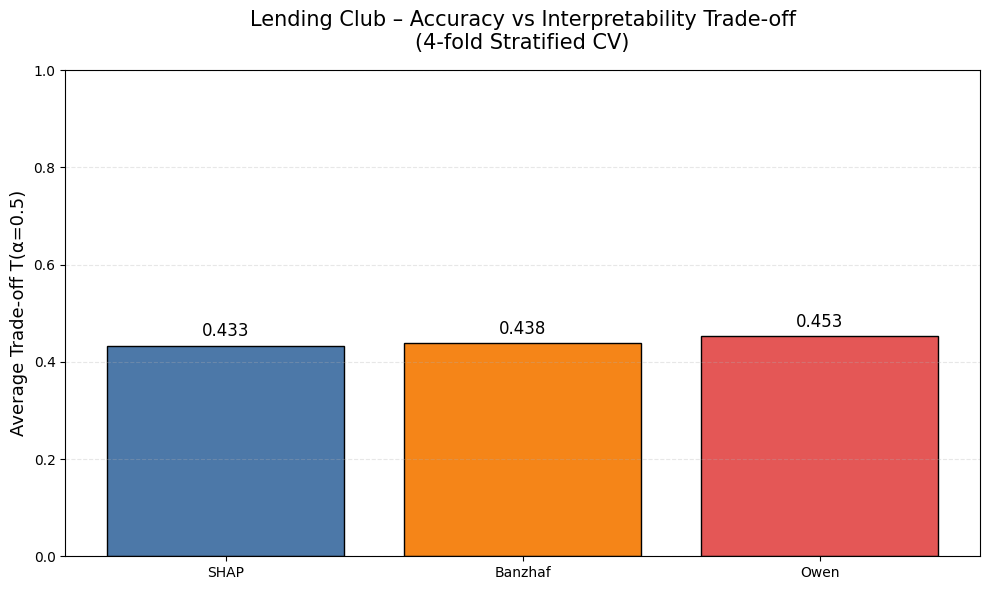

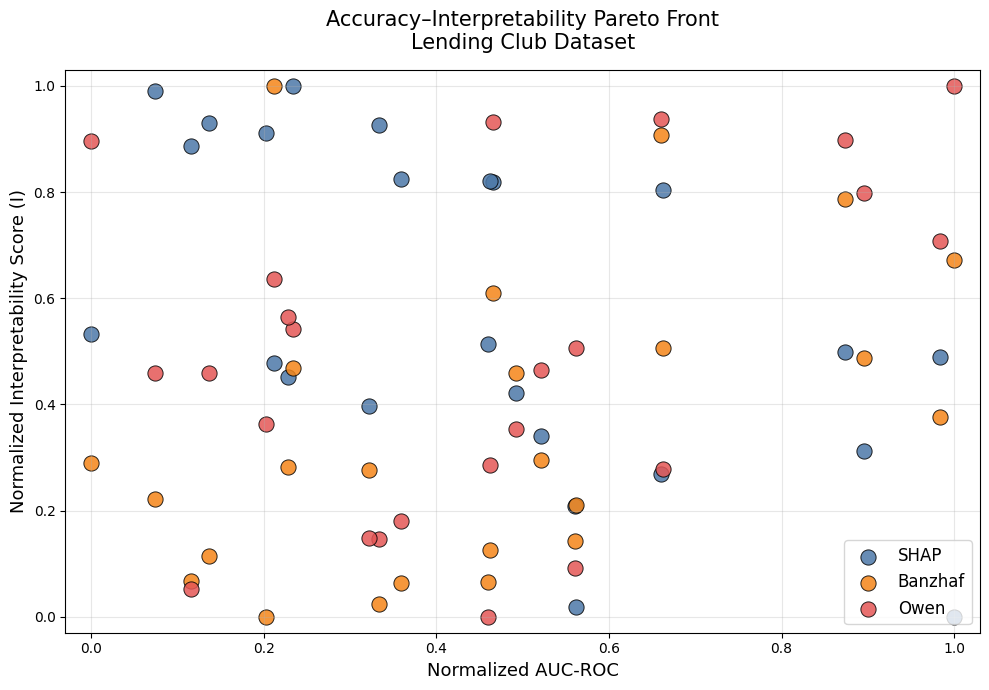

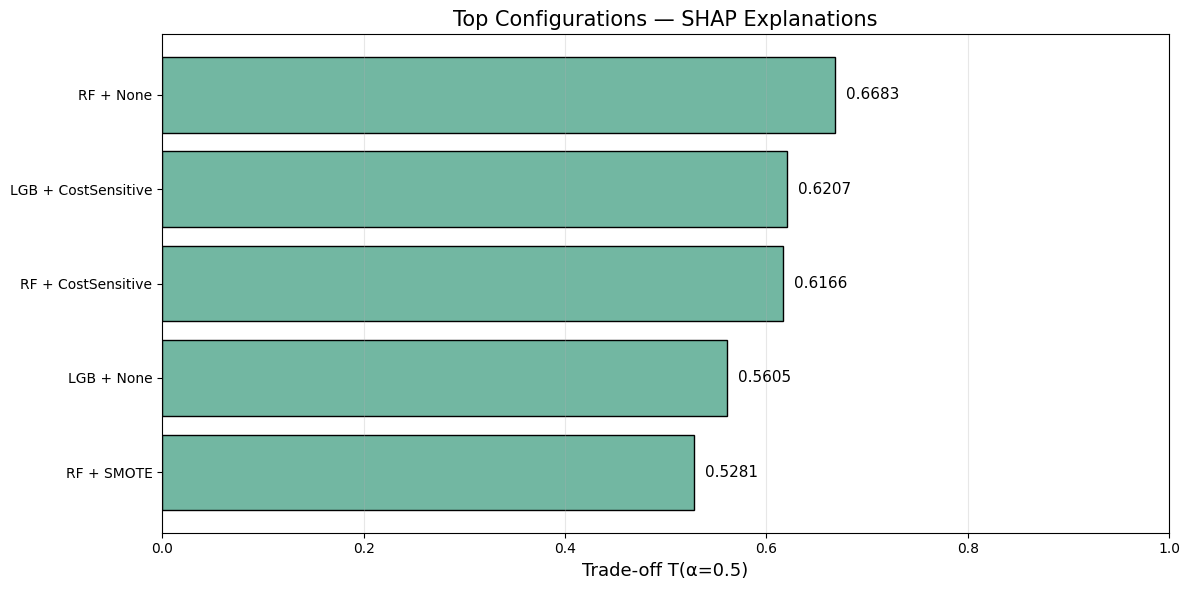

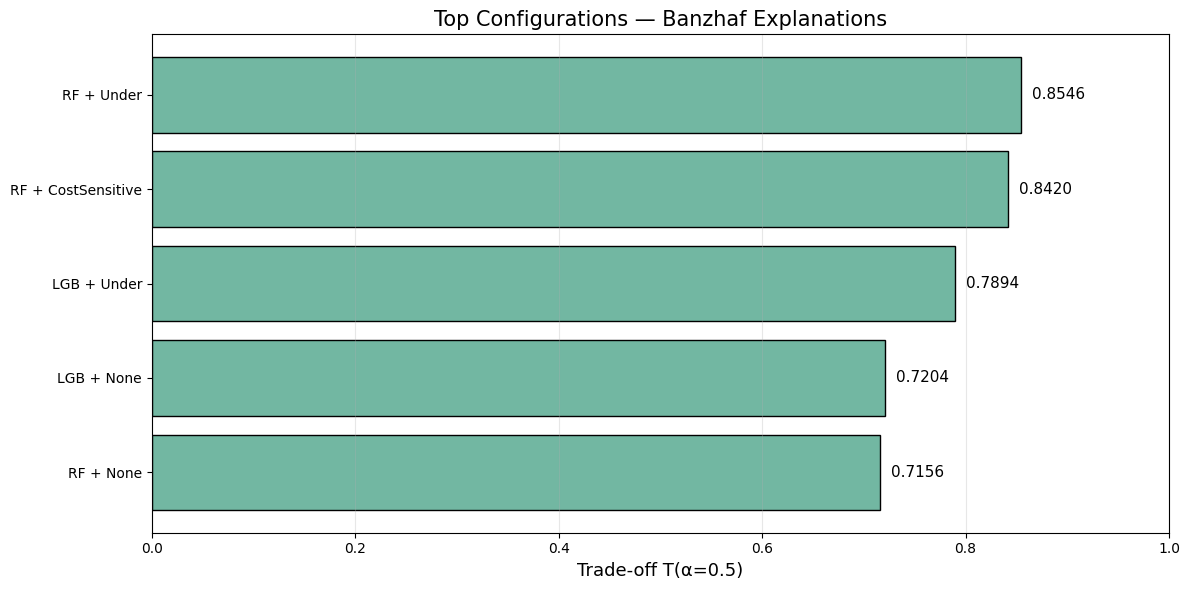

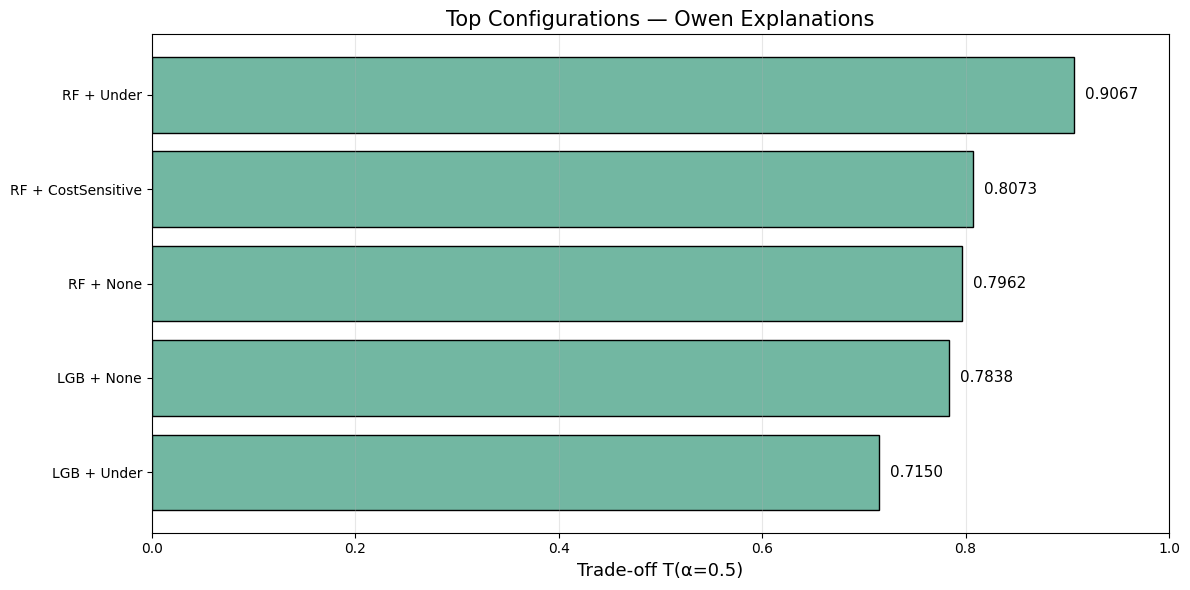

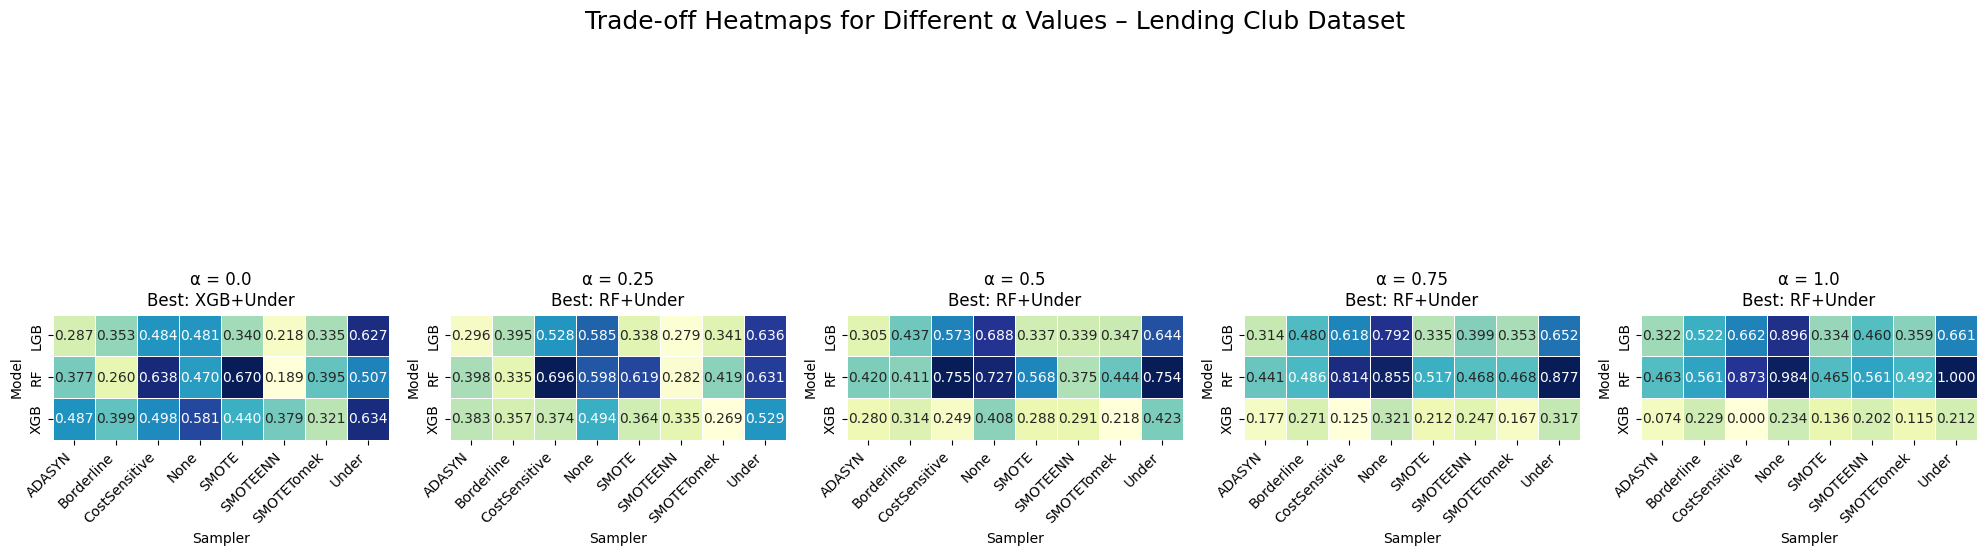


VISUALIZATIONS SAVED AS PNG FILES:
  - lc_tradeoff_by_method.png
  - lc_accuracy_interpretability_scatter.png
  - lc_top5_shap.png, lc_top5_banzhaf.png, lc_top5_owen.png
  - lc_heatmaps_alpha_values.png

SAVING RESULTS TO CSV FILES
✓ Metrics saved to: lc_metrics_results.csv
✓ Summary saved to: lc_summary_results.csv

FINAL SUMMARY

🏆 BEST OVERALL CONFIGURATION:
   Model: RF
   Sampler: Under
   Explanation: Owen
   AUC: 0.6491
   Interpretability (I): 0.7033
   Trade-off T(α=0.5): 0.9067

📊 DATASET STATISTICS:
   Total samples: 50000
   Default rate: 4.00%
   Features used: 9
   - Categorical: 5
   - Numerical: 4

📈 PERFORMANCE SUMMARY:
   Best AUC: 0.6491
   Best Interpretability: 0.7527
   Best Trade-off: 0.9067

🔍 METHOD COMPARISON:
   SHAP:
     - Avg AUC: 0.6217
     - Avg Interpretability: 0.5982
     - Avg Trade-off: 0.4334
   Banzhaf:
     - Avg AUC: 0.6217
     - Avg Interpretability: 0.6008
     - Avg Trade-off: 0.4382
   Owen:
     - Avg AUC: 0.6217
     - Avg Interpretabil

In [1]:
# -*- coding: utf-8 -*-
"""Lending Club Default – Rigorous Accuracy–Interpretability Study (Code B style)"""

# ============================================================
# 1. Install & Imports
# ============================================================
!pip install -q pyspark imbalanced-learn shap lightgbm xgboost seaborn scikit-learn pandas numpy matplotlib

from pyspark.sql import SparkSession
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import shap

plt.style.use('default'); sns.set_palette("husl"); np.random.seed(42)

# ============================================================
# 2. Load & Preprocess Lending Club Dataset with PySpark
# ============================================================
spark = SparkSession.builder \
    .appName("LC_Study") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Load the CSV file
csv_path = 'LC_50K.csv'
spark_df = spark.read.csv(csv_path, header=True, inferSchema=True)

print("Dataset Schema:")
spark_df.printSchema()
print(f"\nTotal Records: {spark_df.count()}")
print(f"Columns: {len(spark_df.columns)}")

# Clean: drop unnecessary columns
columns_to_drop = ['id', 'issue_d', 'zip_code', 'title', 'desc']
existing_columns_to_drop = [col for col in columns_to_drop if col in spark_df.columns]
spark_df = spark_df.drop(*existing_columns_to_drop)

# Rename target column
spark_df = spark_df.withColumnRenamed('Default', 'target')

# Check for missing values and handle them
print("\nChecking for missing values...")
for column in spark_df.columns:
    missing_count = spark_df.filter(spark_df[column].isNull()).count()
    if missing_count > 0:
        print(f"{column}: {missing_count} missing values")
        # Fill numeric columns with median
        if spark_df.schema[column].dataType.typeName() in ['integer', 'double', 'float']:
            median_val = spark_df.approxQuantile(column, [0.5], 0.01)[0]
            spark_df = spark_df.fillna({column: median_val})
        # Fill categorical columns with mode
        else:
            mode_df = spark_df.groupBy(column).count().orderBy('count', ascending=False).limit(1)
            mode_val = mode_df.collect()[0][0] if mode_df.count() > 0 else "Unknown"
            spark_df = spark_df.fillna({column: mode_val})

# Check target distribution
print("\nTarget variable distribution:")
target_dist = spark_df.groupBy("target").count().collect()
for row in target_dist:
    print(f"  Target={row['target']}: {row['count']} records ({(row['count']/spark_df.count()*100):.2f}%)")

# Convert to Pandas for ML (since dataset is small, ~50K rows)
print("\nConverting to Pandas DataFrame for ML...")
df = spark_df.toPandas()
df['target'] = df['target'].astype(int)

print(f"Final dataset shape: {df.shape}")
print(f"Target classes: {df['target'].unique()}")

X = df.drop('target', axis=1)
y = df['target']

# Identify categorical and numeric columns
# Based on your LC_50K dataset structure
cat_cols = ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
# Keep only existing categorical columns
cat_cols = [col for col in cat_cols if col in X.columns]

num_cols = [c for c in X.columns if c not in cat_cols]

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols[:10]}..." if len(num_cols) > 10 else f"Numeric columns ({len(num_cols)}): {num_cols}")

# Sort categories to fix unsorted issue
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# ============================================================
# 3. Models & Samplers
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'Borderline': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'Under': RandomUnderSampler(random_state=42),
    'CostSensitive': 'cost'
}

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}

print(f"\nClass weights: {class_weight_dict}")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# ============================================================
# 4. Explanation Functions (same as Code B)
# ============================================================
def get_shap_reliable(pipe, X_test):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance...")
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc), n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))
    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                # Create random coalition
                coal = np.random.binomial(1, 0.5, n_feat)
                # With feature f
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]
                # Without feature f (set to 0)
                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

# Define feature groups for Lending Club dataset
feature_groups = {
    'Demographic': ['experience_c', 'emp_length', 'home_ownership_n', 'addr_state'],
    'Financial': ['revenue', 'dti_n', 'loan_amnt', 'fico_n'],
    'Purpose': ['purpose']
}

def compute_owen(pipe, X_test, feature_groups, n_samples=3, max_instances=5):
    clf = pipe.named_steps['clf']
    prep = pipe.named_steps['prep']
    X_proc = prep.transform(X_test)
    fnames = prep.get_feature_names_out()

    # Map feature groups to indices
    group_idx = {}
    for g, feats in feature_groups.items():
        indices = []
        for i, name in enumerate(fnames):
            if any(feat in name for feat in feats):
                indices.append(i)
        group_idx[g] = indices

    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                gmask = {g: np.random.choice([0,1]) for g in group_idx}
                mask = np.ones(n_feat)  # Start with all features active

                for g, idxs in group_idx.items():
                    if not gmask[g]:  # If group is inactive, turn off its features
                        mask[idxs] = 0
                    elif f in idxs:  # If feature is in this active group
                        # Randomize within the group for this feature
                        for idx in idxs:
                            if idx != f:  # Keep the current feature as is
                                mask[idx] = np.random.choice([0,1])

                # With feature f
                x_with = x * mask.reshape(1, -1)
                p1 = clf.predict_proba(x_with)[0, 1]

                # Without feature f
                mask_without = mask.copy()
                mask_without[f] = 0
                x_without = x * mask_without.reshape(1, -1)
                p0 = clf.predict_proba(x_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

# ============================================================
# 5. Metrics (identical to Code B)
# ============================================================
def stability_cv(expl_list):
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])  # (n_folds, n_samples, n_features)
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))  # scalar
    except:
        return 1.0

def jaccard_topk(expl_list, k=5):
    if len(expl_list) < 2:
        return 0.0
    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = tuple(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(tuple())

    if len(sets) < 2:
        return 0.0

    sims = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            inter = len(set(sets[i]) & set(sets[j]))
            union = len(set(sets[i]) | set(sets[j]))
            sims.append(inter / union if union > 0 else 0.0)
    return float(np.mean(sims)) if sims else 0.0

def interpretability_score(cv, j, beta=0.5):
    return beta * (1 - cv) + (1 - beta) * j

def normalize(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    return alpha * normalize(auc_series) + (1-alpha) * normalize(I_series)

# ============================================================
# 6. 4-Fold CV Loop (the gold standard)
# ============================================================
print("\n" + "="*80)
print("STARTING 4-FOLD STRATIFIED CROSS-VALIDATION")
print("="*80)

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        aucs = []
        shap_runs, banzhaf_runs, owen_runs = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            # Cost-sensitive learning
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            # Train model
            pipe.fit(X_tr, y_tr)

            # Predict and compute AUC
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f"  Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            # Explanations on small sample
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            # SHAP values
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"    SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

            # Banzhaf values
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"    Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(5, len(X_sample)), n_features)))

            # Owen values
            try:
                owen_vals = compute_owen(pipe, X_sample, feature_groups)
                owen_runs.append(owen_vals)
            except Exception as e:
                print(f"    Owen failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                owen_runs.append(np.zeros((min(5, len(X_sample)), n_features)))

        # Aggregate metrics across folds
        auc_mean = np.mean(aucs)

        # Compute metrics for each explanation method
        for method, runs in zip(['SHAP', 'Banzhaf', 'Owen'],
                               [shap_runs, banzhaf_runs, owen_runs]):
            cv_val = stability_cv(runs)
            jacc = jaccard_topk(runs)
            I = interpretability_score(cv_val, jacc)

            records.append({
                'Model': mname,
                'Sampler': sname,
                'Method': method,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Jaccard': jacc,
                'I': I
            })

# ============================================================
# 7. Results & Visualisations
# ============================================================
print("\n" + "="*80)
print("LENDING CLUB DATASET – FINAL METRICS (4-fold CV)")
print("="*80)

if records:
    metrics = pd.DataFrame(records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print(metrics.round(4).to_string(index=False))

    # Average by explanation method
    print("\n" + "="*80)
    print("Average by Explanation Method")
    print("="*80)
    method_avg = metrics.groupby('Method')[['AUC', 'Stability', 'Jaccard', 'I', 'T(α=0.5)']].mean().round(4)
    print(method_avg)

    # LaTeX tables (copy-paste into thesis)
    print("\n" + "="*80)
    print("LaTeX TABLES FOR THESIS")
    print("="*80)

    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            subset = metrics[metrics['Method'] == method]
            latex = subset[['Model', 'Sampler', 'AUC', 'Stability', 'Jaccard', 'I', 'T(α=0.5)']].round(4).to_latex(
                index=False,
                caption=f"Lending Club Dataset – {method} Results (4-fold CV)",
                label=f"tab:lc_{method.lower()}"
            )
            print(f"\nLaTeX TABLE — {method}:")
            print(latex)

    # Summary table
    summary = metrics.groupby('Method')[['AUC', 'Stability', 'Jaccard', 'I', 'T(α=0.5)']].mean().round(4)
    print("\nSUMMARY LaTeX:")
    print(summary.to_latex(
        caption="Lending Club Dataset – Method Comparison",
        label="tab:lc_summary"
    ))
else:
    print("No results generated. Check for errors above.")
    metrics = pd.DataFrame()

# ============================================================
# 8. FINAL PLOTS – Thesis-ready (Lending Club Dataset)
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING THESIS-READY VISUALIZATIONS")
    print("="*80)

    # Safe normalization function
    def safe_normalize(s: pd.Series):
        mn, mx = s.min(), s.max()
        if mx == mn:
            return pd.Series(0.5, index=s.index)
        return ((s - mn) / (mx - mn)).clip(0, 1)

    metrics = metrics.copy()

    # 1. Average Trade-off by Method
    plt.figure(figsize=(10, 6))

    # Ensure all methods are present
    all_methods = ['SHAP', 'Banzhaf', 'Owen']
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean()
    for method in all_methods:
        if method not in method_avg.index:
            method_avg[method] = 0
    method_avg = method_avg.reindex(all_methods)

    bars = plt.bar(method_avg.index, method_avg.values,
                   color=['#4C78A8', '#F58518', '#E45756'],
                   edgecolor='black', linewidth=1)
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
    plt.ylabel("Average Trade-off T(α=0.5)", fontsize=13)
    plt.title("Lending Club – Accuracy vs Interpretability Trade-off\n(4-fold Stratified CV)",
              fontsize=15, pad=15)
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('lc_tradeoff_by_method.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Accuracy vs Interpretability Scatter (Normalized)
    plt.figure(figsize=(10, 7))
    colors = {'SHAP': '#4C78A8', 'Banzhaf': '#F58518', 'Owen': '#E45756'}

    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            sub = metrics[metrics['Method'] == method]
            plt.scatter(safe_normalize(sub['AUC']), safe_normalize(sub['I']),
                        s=120, label=method, color=colors[method], alpha=0.85,
                        edgecolors='black', linewidth=0.7)

    plt.xlabel("Normalized AUC-ROC", fontsize=13)
    plt.ylabel("Normalized Interpretability Score (I)", fontsize=13)
    plt.title("Accuracy–Interpretability Pareto Front\nLending Club Dataset",
              fontsize=15, pad=15)
    plt.legend(fontsize=12, frameon=True)
    plt.grid(alpha=0.3)
    plt.xlim(-0.03, 1.03)
    plt.ylim(-0.03, 1.03)
    plt.tight_layout()
    plt.savefig('lc_accuracy_interpretability_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Top 5 Configurations per Explanation Method
    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            plt.figure(figsize=(12, 6))
            method_data = metrics[metrics['Method'] == method]
            top5 = method_data.nlargest(min(5, len(method_data)), 'T(α=0.5)')
            labels = [f"{row.Model} + {row.Sampler}" for _, row in top5.iterrows()]
            values = top5['T(α=0.5)'].round(4)

            bars = plt.barh(labels, values, color='#72B7A2', edgecolor='black')
            plt.bar_label(bars, fmt='%.4f', padding=8, fontsize=11)
            plt.xlabel("Trade-off T(α=0.5)", fontsize=13)
            plt.title(f"Top Configurations — {method} Explanations", fontsize=15)
            plt.xlim(0, 1)
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'lc_top5_{method.lower()}.png', dpi=300, bbox_inches='tight')
            plt.show()

    # 4. Heatmap of T(α) for different α
    plt.figure(figsize=(20, 6))
    alphas = [0.0, 0.25, 0.5, 0.75, 1.0]

    for i, alpha in enumerate(alphas):
        col = f'T(α={alpha})'
        metrics[col] = alpha * safe_normalize(metrics['AUC']) + (1 - alpha) * safe_normalize(metrics['I'])

        plt.subplot(1, 5, i + 1)
        heatmap_data = metrics.pivot_table(values=col, index='Model', columns='Sampler', aggfunc='mean')

        # Find best configuration
        best_idx = metrics[col].idxmax() if not metrics[col].empty else 0
        best = metrics.loc[best_idx] if not metrics.empty else None

        sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu',
                   cbar=False, linewidths=.5, square=True)

        if best is not None:
            plt.title(f"α = {alpha}\nBest: {best.Model}+{best.Sampler}", fontsize=12)
        else:
            plt.title(f"α = {alpha}", fontsize=12)

        plt.xticks(rotation=45, ha='right')

    plt.suptitle("Trade-off Heatmaps for Different α Values – Lending Club Dataset",
                 fontsize=18, y=1.08)
    plt.tight_layout()
    plt.savefig('lc_heatmaps_alpha_values.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*80)
    print("VISUALIZATIONS SAVED AS PNG FILES:")
    print("  - lc_tradeoff_by_method.png")
    print("  - lc_accuracy_interpretability_scatter.png")
    print("  - lc_top5_shap.png, lc_top5_banzhaf.png, lc_top5_owen.png")
    print("  - lc_heatmaps_alpha_values.png")
    print("="*80)

# ============================================================
# 9. Save Results to CSV
# ============================================================
print("\n" + "="*80)
print("SAVING RESULTS TO CSV FILES")
print("="*80)

if not metrics.empty:
    # Save metrics
    metrics.to_csv('lc_metrics_results.csv', index=False)
    print("✓ Metrics saved to: lc_metrics_results.csv")

    # Save summary
    summary_table = metrics.groupby('Method')[['AUC', 'Stability', 'Jaccard', 'I', 'T(α=0.5)']].mean().round(4)
    summary_table.to_csv('lc_summary_results.csv')
    print("✓ Summary saved to: lc_summary_results.csv")
else:
    print("✗ No metrics to save")

# ============================================================
# 10. Final Summary and Stop Spark Session
# ============================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

if not metrics.empty:
    # Best overall configuration
    best_overall = metrics.loc[metrics['T(α=0.5)'].idxmax()]
    print(f"\n🏆 BEST OVERALL CONFIGURATION:")
    print(f"   Model: {best_overall['Model']}")
    print(f"   Sampler: {best_overall['Sampler']}")
    print(f"   Explanation: {best_overall['Method']}")
    print(f"   AUC: {best_overall['AUC']:.4f}")
    print(f"   Interpretability (I): {best_overall['I']:.4f}")
    print(f"   Trade-off T(α=0.5): {best_overall['T(α=0.5)']:.4f}")

    # Dataset statistics
    print(f"\n📊 DATASET STATISTICS:")
    print(f"   Total samples: {len(df)}")
    print(f"   Default rate: {(y.mean() * 100):.2f}%")
    print(f"   Features used: {len(cat_cols) + len(num_cols)}")
    print(f"   - Categorical: {len(cat_cols)}")
    print(f"   - Numerical: {len(num_cols)}")

    # Performance summary
    print(f"\n📈 PERFORMANCE SUMMARY:")
    print(f"   Best AUC: {metrics['AUC'].max():.4f}")
    print(f"   Best Interpretability: {metrics['I'].max():.4f}")
    print(f"   Best Trade-off: {metrics['T(α=0.5)'].max():.4f}")

    # Method comparison
    print(f"\n🔍 METHOD COMPARISON:")
    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            method_data = metrics[metrics['Method'] == method]
            print(f"   {method}:")
            print(f"     - Avg AUC: {method_data['AUC'].mean():.4f}")
            print(f"     - Avg Interpretability: {method_data['I'].mean():.4f}")
            print(f"     - Avg Trade-off: {method_data['T(α=0.5)'].mean():.4f}")
else:
    print("\n✗ No results generated. Analysis may have failed.")

# ============================================================
# 11. Cleanup
# ============================================================
print("\n" + "="*80)
print("CLEANING UP")
print("="*80)

# Stop Spark session
spark.stop()
print("✓ Spark session stopped")

print("\n" + "="*80)
if not metrics.empty:
    print("✅ ANALYSIS COMPLETE!")
    print("Results have been saved to CSV files and visualizations generated.")
    print("LaTeX tables are ready for inclusion in your thesis.")
else:
    print("❌ ANALYSIS INCOMPLETE!")
    print("Check error messages above for issues.")
print("="*80)

Comparison of Code A and Code B Results

The results obtained from Code A and Code B highlight the impact of feature space complexity and preprocessing choices on both predictive performance and interpretability outcomes. In Code A, the analysis is intentionally restricted to a small set of five numeric features, resulting in a low-dimensional and fully dense feature space. Under this controlled setting, all models achieve moderate AUC values (approximately 0.59–0.62), and SHAP explanations demonstrate substantially higher stability and overall interpretability compared to Banzhaf and Owen values. This indicates that, when feature interactions and sparsity are minimized, SHAP provides the most consistent and reliable explanations across cross-validation folds, while cooperative game–theoretic methods suffer from higher variance.

Interpretability Shift in the Full-Scale Setting (Code B)

In contrast, Code B extends the analysis to a more realistic modeling scenario by incorporating both numerical and categorical variables, resulting in a high-dimensional feature space after one-hot encoding. While predictive performance improves slightly (with AUC values reaching approximately 0.65 for Random Forest models), explanation behavior changes markedly. In this setting, Banzhaf and Owen explanations exhibit significantly higher stability than SHAP, particularly under under-sampling and cost-sensitive learning strategies. This suggests that group-aware and cooperative explanation methods are more robust to feature sparsity and interaction effects in complex, real-world datasets, whereas SHAP explanations become less stable despite maintaining high Jaccard similarity. These findings demonstrate that interpretability performance is highly context-dependent and that explanation methods behave differently under controlled versus realistic feature representations.